Found 5568 videos in E:\ASL_Citizen\NEW\Top_Classes


100%|██████████████████████████████████████████████████████████████████████████████| 5568/5568 [01:01<00:00, 90.95it/s]


Basic Statistics:
  Total videos: 5568
  Min frames: 15
  Max frames: 664
  Mean frames: 79.4
  Median frames: 71.0
  Std dev: 37.5
  10th percentile: 45.0
  25th percentile: 55.0
  50th percentile: 71.0
  75th percentile: 92.0
  90th percentile: 127.0
  95th percentile: 157.0
  99th percentile: 200.3

Category Counts:
Very Short (1-30)      69
Short (31-60)        1804
Medium (61-120)      3046
Long (121-200)        593
Very Long (201+)       56
Name: count, dtype: int64

Number of outliers: 367
Outlier video examples: ['ABOUT 12.mp4' 'ABOUT 16.mp4' 'ABOUT 18.mp4' 'ABOUT 34.mp4'
 'ABOUT 35.mp4' 'ABOUT 48.mp4' 'ABOUT 62.mp4' 'APPLE 26.mp4' 'AUNT 12.mp4'
 'AUNT 17.mp4']


C:\Users\marha\AppData\Local\Temp\ipykernel_34276\2538930719.py:75: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  B = np.trapz(cumvals, xvals)
C:\Users\marha\AppData\Local\Temp\ipykernel_34276\2538930719.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[7].set_xticklabels(category_counts.index, rotation=45, ha="right")


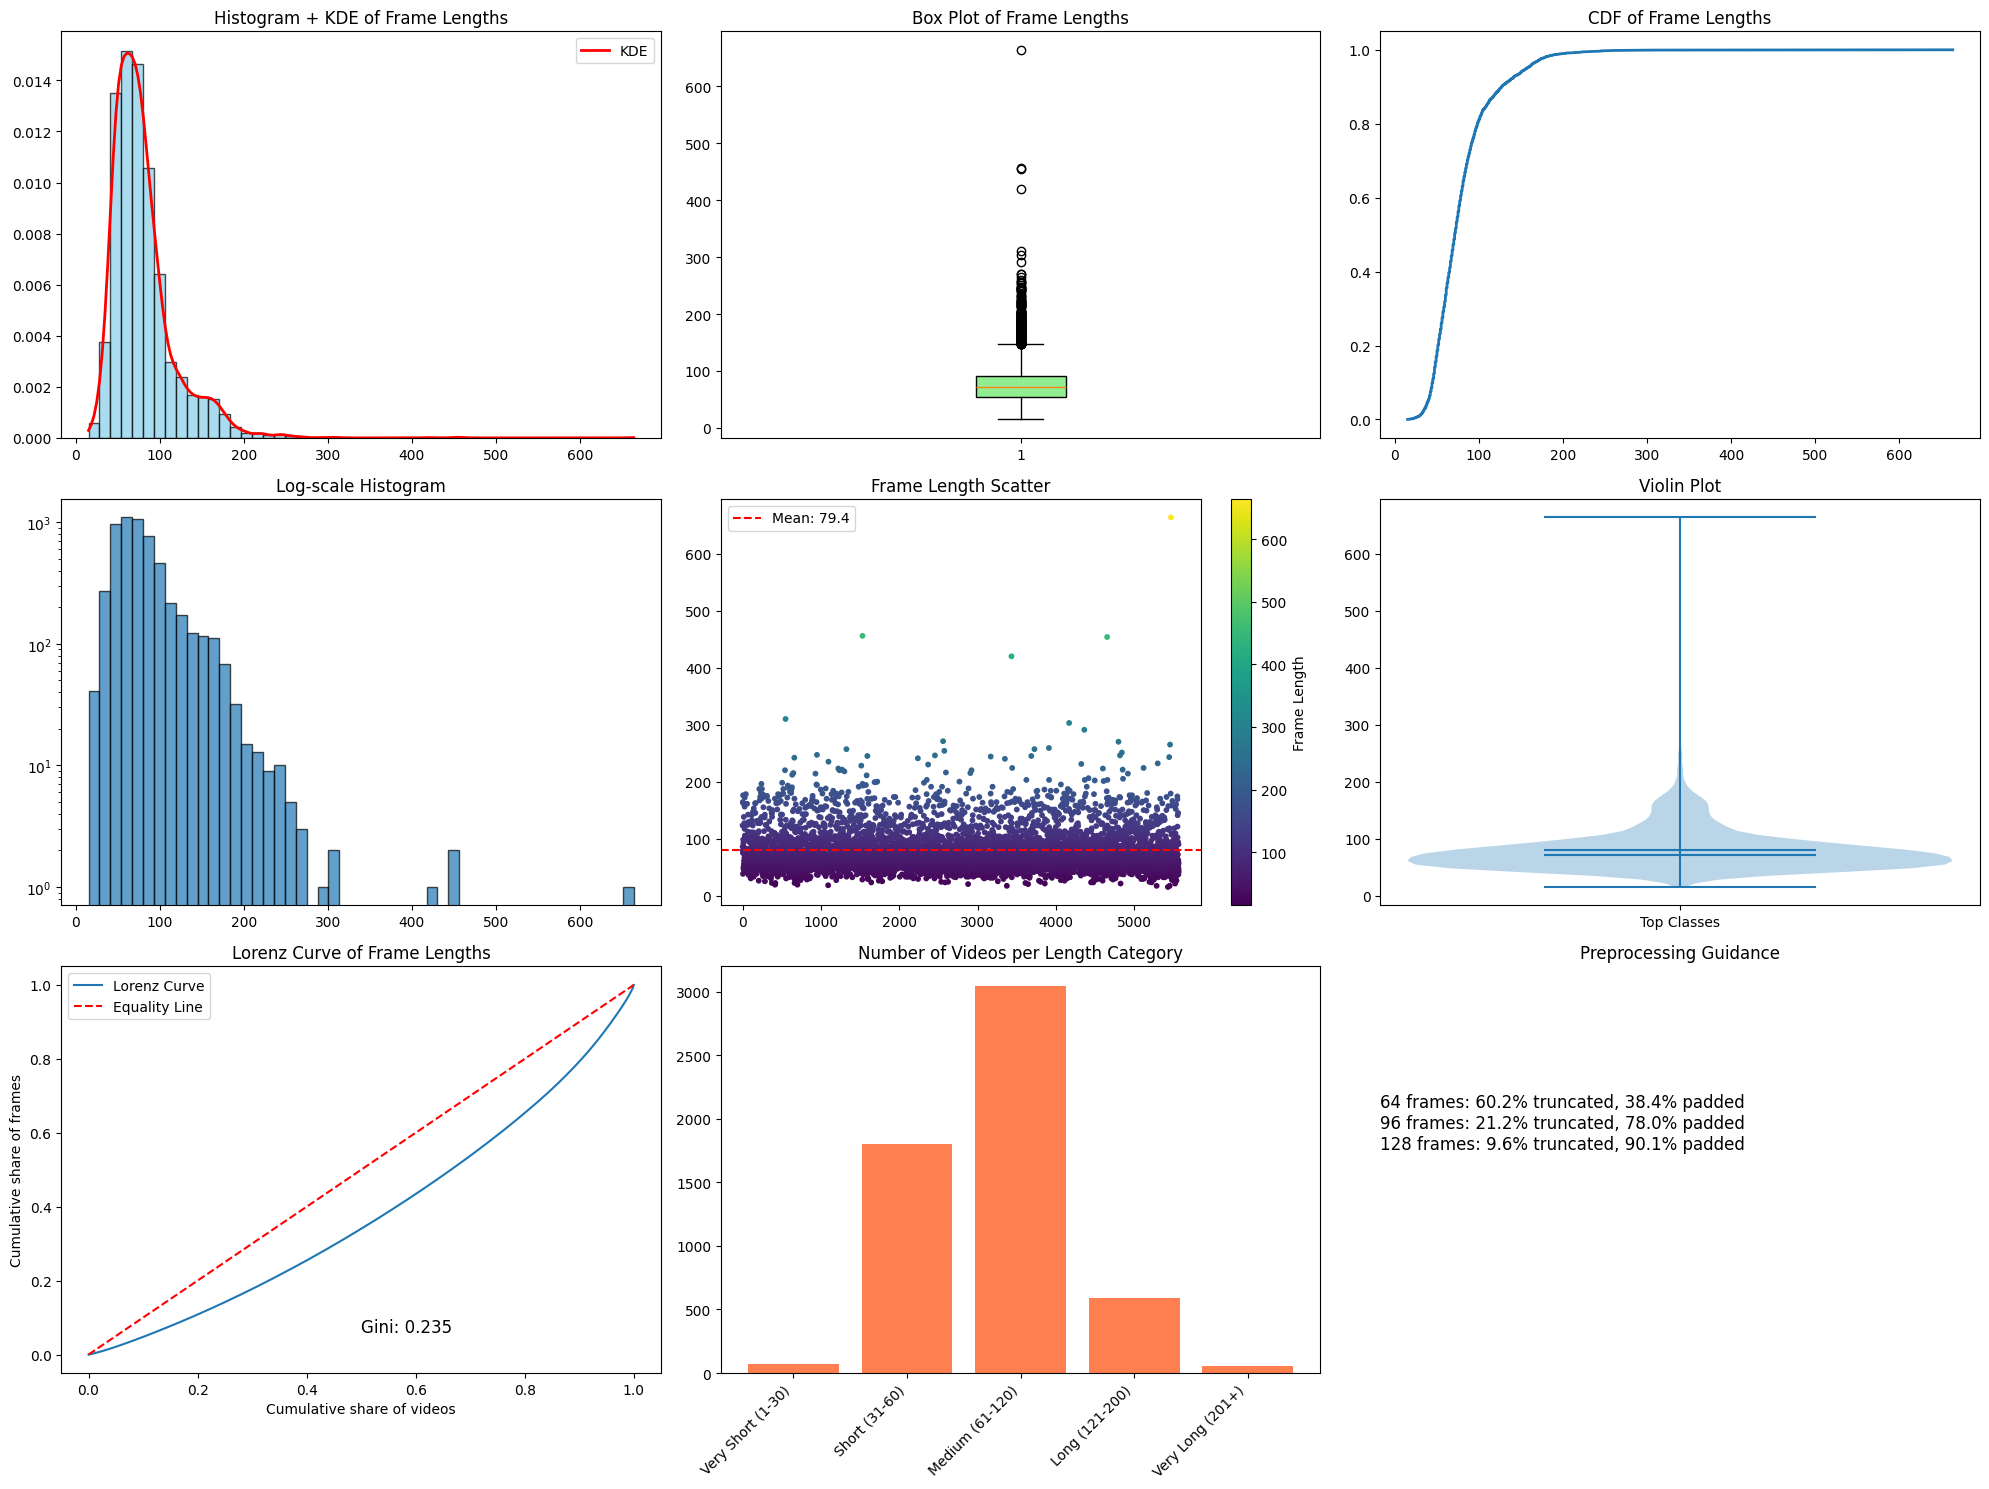


✅ Analysis complete! Figure saved to E:\ASL_Citizen\NEW\enhanced_frame_length_analysis.png, CSV to E:\ASL_Citizen\NEW\frame_length_report.csv, JSON to E:\ASL_Citizen\NEW\frame_length_summary.json


In [6]:
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import json
from scipy.stats import gaussian_kde

# =========================
# CONFIG
# =========================
VIDEO_DIR = r"E:\ASL_Citizen\NEW\Top_Classes"
FIG_SAVE_PATH = r"E:\ASL_Citizen\NEW\enhanced_frame_length_analysis.png"
CSV_SAVE_PATH = r"E:\ASL_Citizen\NEW\frame_length_report.csv"
JSON_SAVE_PATH = r"E:\ASL_Citizen\NEW\frame_length_summary.json"

# =========================
# 1️⃣ Collect frame lengths
# =========================
def collect_frame_lengths(video_dir):
    video_files = list(Path(video_dir).glob("*.mp4"))
    frame_lengths = []
    file_names = []

    if len(video_files) == 0:
        raise ValueError(f"No .mp4 videos found in {video_dir}")

    print(f"Found {len(video_files)} videos in {video_dir}")

    for vf in tqdm(video_files):
        cap = cv2.VideoCapture(str(vf))
        if not cap.isOpened():
            print(f"⚠️ Failed to open video: {vf.name}")
            continue
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if length > 0:
            frame_lengths.append(length)
            file_names.append(vf.name)
        else:
            print(f"⚠️ Video has zero frames: {vf.name}")
        cap.release()

    if len(frame_lengths) == 0:
        raise ValueError("No videos could be read successfully!")

    return np.array(frame_lengths), file_names

# =========================
# 2️⃣ Categorize lengths
# =========================
def categorize_lengths(frame_lengths):
    bins = [0,30,60,120,200,np.inf]
    labels = ["Very Short (1-30)","Short (31-60)","Medium (61-120)","Long (121-200)","Very Long (201+)"]
    categories = pd.cut(frame_lengths, bins=bins, labels=labels)
    return categories

# =========================
# 3️⃣ Lorenz curve & Gini
# =========================
def lorenz_curve(values, ax=None):
    sorted_vals = np.sort(values)
    cumvals = np.cumsum(sorted_vals)
    cumvals = cumvals / cumvals[-1]
    xvals = np.linspace(0,1,len(values))
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(np.append([0], xvals), np.append([0], cumvals), label="Lorenz Curve")
    ax.plot([0,1],[0,1], linestyle="--", color="red", label="Equality Line")
    ax.set_xlabel("Cumulative share of videos")
    ax.set_ylabel("Cumulative share of frames")
    ax.set_title("Lorenz Curve of Frame Lengths")
    ax.legend()
    B = np.trapz(cumvals, xvals)
    Gini = 1 - 2*B
    return Gini

# =========================
# 4️⃣ Analysis & plotting
# =========================
def analyze_and_plot(frame_lengths, file_names):
    # Basic stats
    print("Basic Statistics:")
    print(f"  Total videos: {len(frame_lengths)}")
    print(f"  Min frames: {frame_lengths.min()}")
    print(f"  Max frames: {frame_lengths.max()}")
    print(f"  Mean frames: {frame_lengths.mean():.1f}")
    print(f"  Median frames: {np.median(frame_lengths):.1f}")
    print(f"  Std dev: {frame_lengths.std():.1f}")
    for p in [10,25,50,75,90,95,99]:
        print(f"  {p}th percentile: {np.percentile(frame_lengths,p):.1f}")

    # Categorize
    categories = categorize_lengths(frame_lengths)
    category_counts = categories.value_counts().sort_index()
    print("\nCategory Counts:")
    print(category_counts)

    # Outliers
    Q1 = np.percentile(frame_lengths, 25)
    Q3 = np.percentile(frame_lengths, 75)
    IQR = Q3-Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = np.array(file_names)[(frame_lengths<lower) | (frame_lengths>upper)]
    print(f"\nNumber of outliers: {len(outliers)}")
    if len(outliers)>0:
        print("Outlier video examples:", outliers[:10])

    # Plotting
    fig, axes = plt.subplots(3,3, figsize=(20,15))
    axes = axes.flatten()

    # Histogram + KDE
    axes[0].hist(frame_lengths, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    kde = gaussian_kde(frame_lengths)
    x_vals = np.linspace(frame_lengths.min(), frame_lengths.max(), 200)
    axes[0].plot(x_vals, kde(x_vals), color='red', lw=2, label='KDE')
    axes[0].set_title("Histogram + KDE of Frame Lengths")
    axes[0].legend()

    # Box plot
    axes[1].boxplot(frame_lengths, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
    axes[1].set_title("Box Plot of Frame Lengths")

    # CDF
    sorted_lengths = np.sort(frame_lengths)
    cdf = np.arange(1,len(sorted_lengths)+1)/len(sorted_lengths)
    axes[2].plot(sorted_lengths, cdf, linewidth=2)
    axes[2].set_title("CDF of Frame Lengths")

    # Log-scale histogram
    axes[3].hist(frame_lengths, bins=50, edgecolor='black', alpha=0.7, log=True)
    axes[3].set_title("Log-scale Histogram")

    # Scatter
    sc = axes[4].scatter(range(len(frame_lengths)), frame_lengths, c=frame_lengths, cmap='viridis', s=10)
    axes[4].axhline(frame_lengths.mean(), color='red', linestyle='--', label=f'Mean: {frame_lengths.mean():.1f}')
    axes[4].set_title("Frame Length Scatter")
    axes[4].legend()
    plt.colorbar(sc, ax=axes[4], label='Frame Length')

    # Violin plot
    parts = axes[5].violinplot([frame_lengths], showmeans=True, showmedians=True)
    axes[5].set_xticks([1])
    axes[5].set_xticklabels(['Top Classes'])
    axes[5].set_title("Violin Plot")

    # Lorenz curve
    Gini = lorenz_curve(frame_lengths, axes[6])
    axes[6].text(0.5,0.1,f"Gini: {Gini:.3f}",transform=axes[6].transAxes, fontsize=12)

    # Category bar chart
    axes[7].bar(category_counts.index.astype(str), category_counts.values, color='coral')
    axes[7].set_title("Number of Videos per Length Category")
    axes[7].set_xticklabels(category_counts.index, rotation=45, ha="right")

    # Percent truncated/padded at standard targets
    targets = [64,96,128]
    pct_text = ""
    for t in targets:
        truncated = np.mean(frame_lengths>t)*100
        padded = np.mean(frame_lengths<t)*100
        pct_text += f"{t} frames: {truncated:.1f}% truncated, {padded:.1f}% padded\n"
    axes[8].axis('off')
    axes[8].text(0,0.5,pct_text, fontsize=12)
    axes[8].set_title("Preprocessing Guidance")

    plt.tight_layout()
    plt.savefig(FIG_SAVE_PATH, dpi=150, bbox_inches='tight')
    plt.show()

    # Save CSV
    df_report = pd.DataFrame({
        "Video": file_names,
        "Frame_Length": frame_lengths,
        "Category": categories
    })
    df_report.to_csv(CSV_SAVE_PATH, index=False)

    # Save JSON
    summary = {
        "total_videos": len(frame_lengths),
        "mean_length": float(frame_lengths.mean()),
        "median_length": float(np.median(frame_lengths)),
        "min_length": int(frame_lengths.min()),
        "max_length": int(frame_lengths.max()),
        "std_length": float(frame_lengths.std()),
        "percentiles": {p: float(np.percentile(frame_lengths,p)) for p in [10,25,50,75,90,95,99]},
        "Gini": float(Gini),
        "category_counts": category_counts.to_dict()
    }
    with open(JSON_SAVE_PATH,"w") as f:
        json.dump(summary,f,indent=2)

    print(f"\n✅ Analysis complete! Figure saved to {FIG_SAVE_PATH}, CSV to {CSV_SAVE_PATH}, JSON to {JSON_SAVE_PATH}")

# =========================
# MAIN
# =========================
if __name__=="__main__":
    frame_lengths, file_names = collect_frame_lengths(VIDEO_DIR)
    analyze_and_plot(frame_lengths, file_names)


In [7]:
import pandas as pd
import numpy as np

# Load CSV report
CSV_PATH = "frame_length_report.csv"
df = pd.read_csv(CSV_PATH)

frame_lengths = df["Frame_Length"].values

# Compute key statistics
median_len = int(np.median(frame_lengths))
p95_len = int(np.percentile(frame_lengths, 95))
p99_len = int(np.percentile(frame_lengths, 99))

# The most suitable length: 95th percentile
suitable_length = p95_len

print("📊 Recommended target frame length for preprocessing (your dataset):")
print(f" - Most suitable: {suitable_length} frames (≈95% of videos fit fully)")
print(f" - Median: {median_len} frames (for balanced padding/truncation)")
print(f" - 99th percentile: {p99_len} frames (for almost all videos)")

# Optional: show truncation/padding if using this target
trunc_rate = np.mean(frame_lengths > suitable_length) * 100
pad_rate = np.mean(frame_lengths < suitable_length) * 100

print(f"\n💡 Using {suitable_length} frames:")
print(f" - Videos to truncate: {trunc_rate:.1f}%")
print(f" - Videos to pad: {pad_rate:.1f}%")

📊 Recommended target frame length for preprocessing (your dataset):
 - Most suitable: 157 frames (≈95% of videos fit fully)
 - Median: 71 frames (for balanced padding/truncation)
 - 99th percentile: 200 frames (for almost all videos)

💡 Using 157 frames:
 - Videos to truncate: 4.9%
 - Videos to pad: 95.0%
